[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pyinat/pyinaturalist/main?filepath=examples%2FData%2520Visualizations%2520-%2520Seaborn.ipynb)

# Seaborn examples
Here are some examples of visualizations that can be created using [Seaborn](https://seaborn.pydata.org/).

In [ ]:
import json
from datetime import datetime
from dateutil import tz
from os.path import exists
from pprint import pprint

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import dates
from matplotlib import pyplot as plt

from pyinaturalist import get_observations, get_places_autocomplete

BASIC_OBS_COLUMNS = [
    'id', 'observed_on', 'location', 'uri', 'taxon.id',
    'taxon.name', 'taxon.rank', 'taxon.preferred_common_name', 'user.login',
]
DATASET_FILENAME = 'midwest_monarchs.json'
PLOT_COLOR = '#fa7b23'
MIDWEST_STATE_IDS = [3, 20, 24, 25, 28, 32, 35, 38]  # place_ids of 8 states in the Midwest US

sns.set_theme(style="darkgrid")

In [2]:
def date_to_mpl_day_of_year(dt):
    """Get a matplotlib-compatible date number, ignoring the year (to represent day of year)"""
    try:
        return dates.date2num(dt.replace(year=datetime.now().year))
    except ValueError:
        return None

def date_to_mpl_time(dt):
    """Get a matplotlib-compatible date number, ignoring the date (to represent time of day)"""
    try:
        return date_to_num(dt) % 1
    except ValueError:
        return None

def to_local_tz(dt):
    """Convert a datetime object to the local time zone"""
    try:
        return dt.astimezone(tz.tzlocal())
    except (TypeError, ValueError):
        return None
                
def get_xlim():
    """Get limits of x axis for first and last days of the year"""
    now = datetime.now()
    xmin = dates.date2num(datetime(now.year, 1, 1))
    xmax = dates.date2num(datetime(now.year, 12, 31))
    return xmin, xmax

def get_colormap(color):
    """Make a colormap (gradient) based on the given color; copied from seaborn.axisgrid"""
    color_rgb = mpl.colors.colorConverter.to_rgb(color)
    colors = [sns.set_hls_values(color_rgb, l=l) for l in np.linspace(1, 0, 12)]
    return sns.blend_palette(colors, as_cmap=True)

def pdir(obj, sort_types=False, non_callables=False):
    attrs = {attr: type(getattr(obj, attr)).__name__ for attr in dir(obj)}
    if sort_types:
        attrs = {k: v for k, v in sorted(attrs.items(), key=lambda x: x[1])}
    if non_callables:
        attrs = {k: v for k, v in attrs.items() if v not in ['function', 'method', 'method-wrapper', 'builtin_function_or_method']}
    pprint(attrs, sort_dicts=not sort_types)

## Get all observations for a given place and species

In [478]:
# Optional: search for a place ID by name
response = get_places_autocomplete(q='iowa')
pprint({p['id']: p['name'] for p in  response['results']})

{24: 'Iowa',
 1911: 'Iowa',
 2840: 'Iowa',
 8680: 'Iowa City',
 119385: 'Iowa Wetland Management District',
 125537: 'Terry Trueblood Wetland Exploration Trail',
 137891: 'Pammel State Park, Winterset, Iowa',
 151098: 'Mount Vernon, Iowa walking path',
 161392: 'Upper Iowa River Wildlife Management Areas',
 172799: 'Ashton Prairie'}


In [ ]:
# TODO: This should be done with the /observations/histogram endpoint instead

# Optional: reload from previously loaded results, if available
#if exists(DATASET_FILENAME):
#    with open(DATASET_FILENAME) as f:
#        observations = json.load(f)
#else:

observations = get_observations(
    taxon_name='Danaus plexippus',
    photos=True,
    geo=True,
    geoprivacy='open',
    place_id=MIDWEST_STATE_IDS,
    page='all',
)
# Save results for future usage
with open(DATASET_FILENAME, 'w') as f:
    json.dump(observations, f, indent=4, sort_keys=True, default=str)
        
print(f'Total observations: {len(observations)}')

## Data cleanup

In [453]:
# Flatten nested JSON values
df = pd.json_normalize(observations)

# Normalize timezones
df['observed_on'] = df['observed_on'].dropna().apply(to_local_tz)

# Add some extra date/time columns that matplotlib can more easily handle
df['observed_time_mp'] = df['observed_on'].apply(date_to_mpl_time)
df['observed_on_mp'] = df['observed_on'].apply(date_to_mpl_day_of_year)

In [397]:
# Optional: narrow down to just a few columns of interest
#pprint(list(sorted(df.columns)))
#df = df[OBS_COLUMNS]

# Optional: Hacky way of setting limits by adding outliers
# JointGrid + hexbin doesn't make it easy to do this the 'right' way without distorting the plot
#df2 = pd.DataFrame([
#    {'observed_on': datetime(2020, 1, 1, 0, 0, 0, tzinfo=tz.tzlocal()), 'quality_grade': 'research'},
#    {'observed_on': datetime(2020, 12, 31, 23, 59, 59, tzinfo=tz.tzlocal()), 'quality_grade': 'research'},
#])
#df = df.append(df2)

## Basic seasonality plot: observation counts by month & quality grade

In [455]:
# Preview: Show counts by month observed X quality grade
df['observed_month'] = df['observed_on'].apply(lambda x: x.month)
df[['observed_month', 'quality_grade']].groupby(['observed_month', 'quality_grade']).size().reset_index(name='counts')

,observed_month,quality_grade,counts
0,1.0,casual,3
1,3.0,casual,1
2,4.0,casual,4
3,4.0,research,29
4,5.0,casual,2
5,5.0,research,309
6,6.0,casual,20
7,6.0,research,1479
8,7.0,casual,21
9,7.0,needs_id,2


<AxesSubplot:xlabel='observed_month', ylabel='Count'>

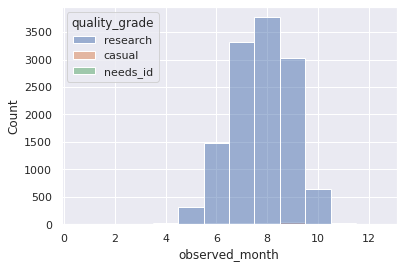

In [456]:
# Plot the same data on a simple histogram
sns.histplot(data=df, x='observed_month', hue='quality_grade', bins=12, discrete=True)

## More detailed seasonality plot: observation counts by month observed & time of day

This plot uses a joint hexbin plot with marginal distributions.

It attempts to answer the question "When is the best time to see monarch butterfies in the Midwest US?"

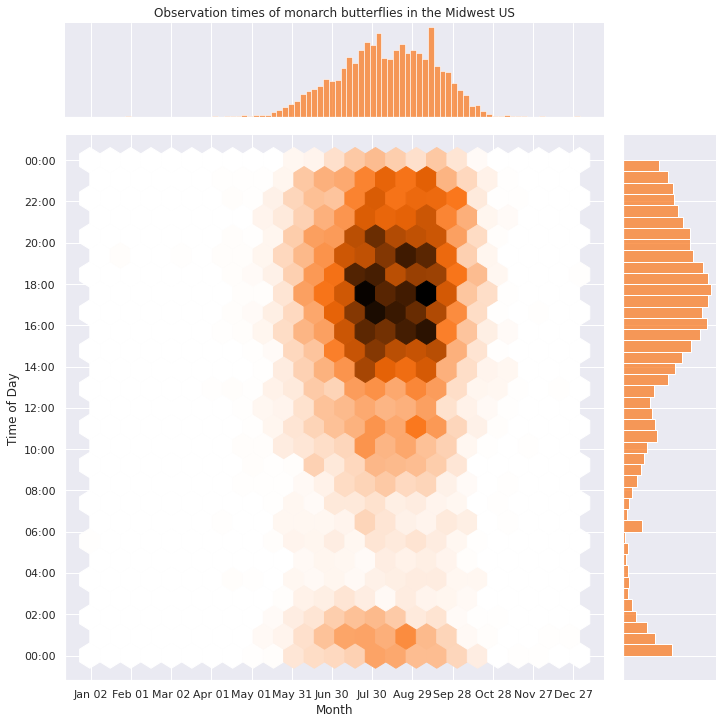

In [471]:
grid = sns.JointGrid(data=df, x='observed_on_mp', y='observed_time_mp', height=10, dropna=True)
grid.ax_marg_x.set_title('Observation times of monarch butterflies in the Midwest US')

# Format X axis labels & ticks
xaxis = grid.ax_joint.get_xaxis()
xaxis.label.set_text('Month')
xaxis.set_major_locator(dates.DayLocator(interval=30))
xaxis.set_major_formatter(dates.DateFormatter('%b %d'))
#xaxis.set_minor_locator(dates.DayLocator(interval=7))
#xaxis.set_minor_formatter(dates.DateFormatter('%d'))

# Format Y axis labels & ticks
yaxis = grid.ax_joint.get_yaxis()
yaxis.label.set_text('Time of Day')
yaxis.set_major_locator(dates.HourLocator(interval=2))
yaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
#yaxis.set_minor_locator(dates.HourLocator())
#yaxis.set_minor_formatter(dates.DateFormatter('%H:%M'))

# Generate a joint plot with marginal plots
# Using the hexbin plotting function, because hexagons are the bestagons.
# Also because it looks just a little like butterfly scales.
grid.plot_joint(plt.hexbin, gridsize=24, cmap=get_colormap(PLOT_COLOR))
grid.plot_marginals(sns.histplot, color=PLOT_COLOR, kde=False)

### Alternate version with shorter syntax but messier labels

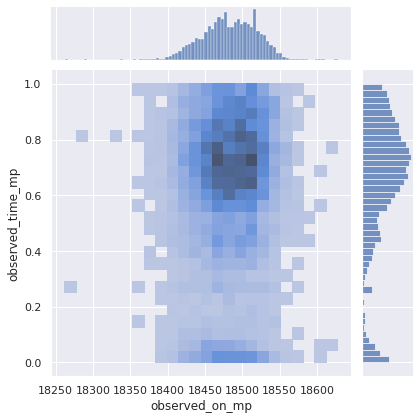

In [475]:
sns.jointplot(data=df, x='observed_on_mp', y='observed_time_mp', bins=24, kind='hist')